In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(len(gpus))
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1


In [4]:
import imghdr
import cv2

In [5]:
data_dir = 'data'
dir_list = os.listdir(data_dir)
print(dir_list)

['other_form_images', 'cheque_images']


In [48]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
for image_class in dir_list:
    print(image_class)
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            print(e)

other_form_images
cheque_images


In [49]:
from PIL import Image
for image_class in dir_list:
    print(image_class)
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            im = Image.open(image_path)
            im.verify()
        except Exception as e:
            print(image_path)
            os.remove(image_path)
            print('Error', e)
#shutil.rmtree('data/cheque_images/.ipynb_checkpoints')

other_form_images
cheque_images


In [50]:
import numpy as np
from matplotlib import pyplot as plt

In [51]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 10617 files belonging to 2 classes.


In [52]:
data_iterator = data.as_numpy_iterator()

In [53]:
batch = data_iterator.next()

In [54]:
batch[1]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

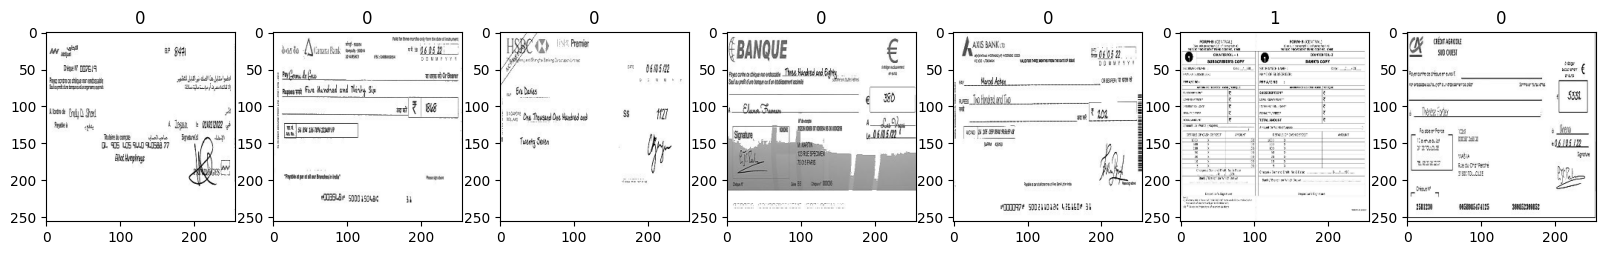

In [55]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, image in enumerate(batch[0][:7]):
    ax[idx].imshow(image.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [56]:
# Class 1 = Non-Cheque
# Class 0 = Cheque
data = data.map(lambda x, y: (x/256, y))

In [57]:
scaled_iterator = data.as_numpy_iterator()

In [58]:
batch = scaled_iterator.next()

In [59]:
batch[0].max()

0.99609375

In [60]:
train_size = int(len(data)*.7)
print(train_size)
val_size = int(len(data)*.2)
print(val_size)
test_size = int(len(data)*.1)+1
print(test_size)

232
66
34


In [61]:
train_size + val_size + test_size

332

In [62]:
len(data)

332

In [63]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [64]:
len(test)

34

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [72]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [73]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

In [75]:
logdir = 'logs'

In [76]:
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [77]:
history = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callbacks])

Epoch 1/3
232/232 [==============================] - 28s 119ms/step - loss: 0.1055 - accuracy: 0.9744 - val_loss: 0.0223 - val_accuracy: 0.9957
Epoch 2/3
232/232 [==============================] - 27s 117ms/step - loss: 0.0327 - accuracy: 0.9923 - val_loss: 1.9575e-04 - val_accuracy: 1.0000
Epoch 3/3
232/232 [==============================] - 27s 117ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0057 - val_accuracy: 0.9991


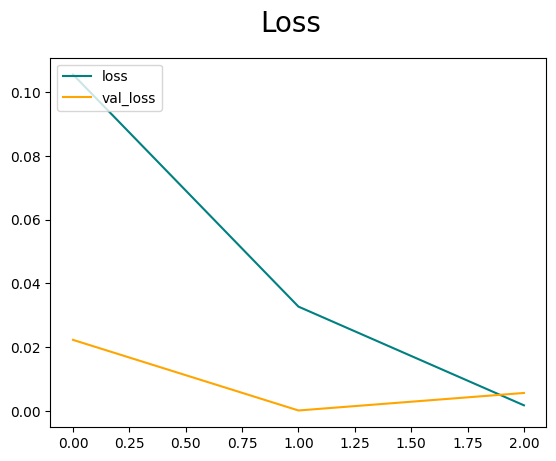

In [78]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

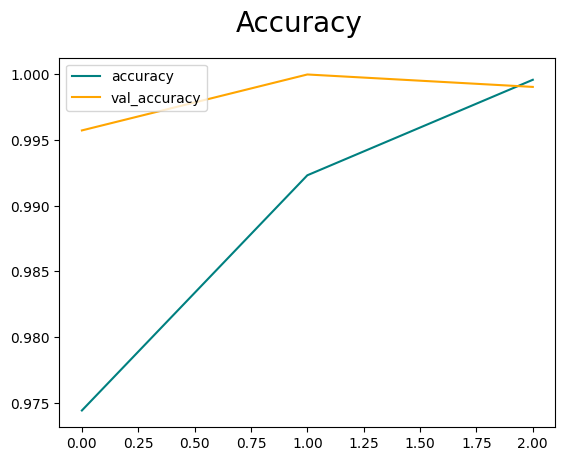

In [79]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [80]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [81]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [82]:
len(test)

34

In [83]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 293ms/step
Precision: 1.0, Recall:0.9824561476707458, Accuracy:0.9990749359130859


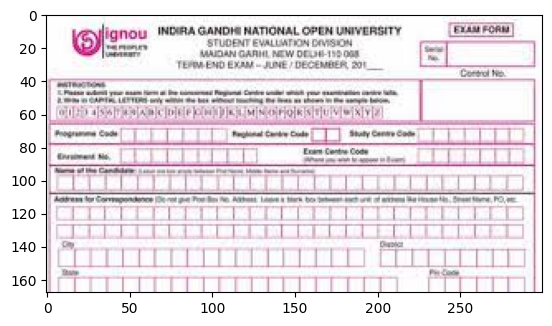

In [93]:
img = cv2.imread('download.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

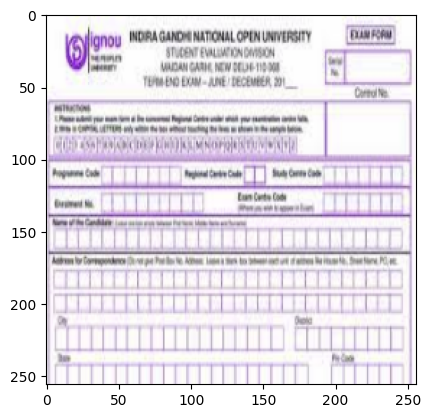

In [94]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [95]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 61ms/step


array([[0.9973556]], dtype=float32)

In [96]:
if yhat > 0.5:
    print("Non-Cheque")
else:
    print("Cheque")

Non-Cheque


In [97]:
model.save(os.path.join('model'))

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [98]:
from tensorflow.keras.models import load_model
new_model = load_model('model')

In [99]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      